In [1]:
from sklearn.utils import resample
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from theano import shared, tensor
import pymc3 as pm
import rpy2.robjects as robjects
import random
import decimal
import bisect
import pickle
import import_ipynb
import datetime
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
train = pd.read_csv('/Users/pol.molinas/Downloads/Kaggle/Predict Future Sales/sales_train.csv')
test = pd.read_csv('/Users/pol.molinas/Downloads/Kaggle/Predict Future Sales/test.csv')
submission = pd.read_csv('/Users/pol.molinas/Downloads/Kaggle/Predict Future Sales/sample_submission.csv')
items = pd.read_csv('/Users/pol.molinas/Downloads/Kaggle/Predict Future Sales/items.csv')
item_cats = pd.read_csv('/Users/pol.molinas/Downloads/Kaggle/Predict Future Sales/item_categories.csv')
shops = pd.read_csv('/Users/pol.molinas/Downloads/Kaggle/Predict Future Sales/shops.csv')

In [3]:
train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

### Train model only on items and shops contained in Test

In [4]:
train = train[(train.shop_id.isin(test.shop_id.unique())) & 
                 train.item_id.isin(test.item_id.unique())]

### Check for outliers

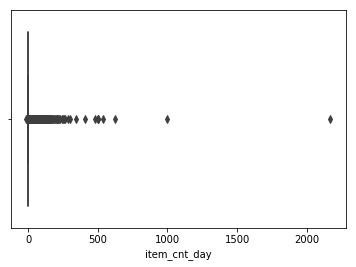

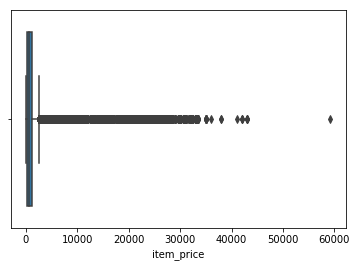

In [5]:
plt.figure()
sns.boxplot(x = train.item_cnt_day)
plt.figure()
sns.boxplot(x = train.item_price)

In [6]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [7]:
train[train.item_price<0] = train[(train.shop_id==32)&
                                  (train.item_id==2973)&
                                  (train.date_block_num==4)&
                                  (train.item_price>0)].item_price.median()

### Duplicates

In [8]:
print(sum(train.duplicated(['date_block_num','shop_id','item_id','item_cnt_day'])))
train.drop_duplicates(['date_block_num','shop_id','item_id','item_cnt_day'], inplace=True)

535320


### Create Train Dataframe

In [9]:
from itertools import product
block_shop_combi = pd.DataFrame(list(product(np.arange(34), test.shop_id.unique())), columns=['date_block_num','shop_id'])
shop_item_combi = pd.DataFrame(list(product(test.shop_id.unique(), test.item_id.unique())), columns=['shop_id','item_id'])
all_combi = pd.merge(block_shop_combi, shop_item_combi, on=['shop_id'], how='inner')
train_2 = pd.merge(all_combi, train, on=['date_block_num','shop_id','item_id'], how='left')

### Group by month

In [10]:
train_group = train_2.groupby(['date_block_num','shop_id','item_id']).agg(
    {'item_cnt_day': ['sum','count']}).reset_index()
train_group.columns = ['date_block_num', 'shop_id',	'item_id','item_cnt','item_order']

### Make Features

In [11]:
train_group.head()

,date_block_num,shop_id,item_id,item_cnt,item_order
0,0,2,30,0.0,0
1,0,2,31,0.0,0
2,0,2,32,0.0,0
3,0,2,33,1.0,1
4,0,2,38,0.0,0


In [12]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [13]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [14]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [15]:
item_cat_split = pd.DataFrame([i.split('-') for i in item_cats.item_category_name])
item_cats['item_cat_1'] = item_cat_split[0]
item_cats['item_cat_2'] = item_cat_split[1]
item_cats.head()

,item_category_name,item_category_id,item_cat_1,item_cat_2
0,PC - Гарнитуры/Наушники,0,PC,Гарнитуры/Наушники
1,Аксессуары - PS2,1,Аксессуары,PS2
2,Аксессуары - PS3,2,Аксессуары,PS3
3,Аксессуары - PS4,3,Аксессуары,PS4
4,Аксессуары - PSP,4,Аксессуары,PSP


In [16]:
train_group = pd.merge(train_group,items[['item_id','item_category_id']],on = 'item_id',how='left').merge(
                        item_cats[['item_category_id','item_cat_1','item_cat_2']],on='item_category_id',how='left').merge(
                        train[['item_id','item_price']],on='item_id',how='left')
train_group['revenue'] = train_group.item_cnt * train_group.item_price

In [17]:
train_group.head()

,date_block_num,shop_id,item_id,item_cnt,item_order,item_category_id,item_cat_1,item_cat_2,item_price,revenue
0,0,2,30,0.0,0,40,Кино,DVD,399.0,0.0
1,0,2,30,0.0,0,40,Кино,DVD,399.0,0.0
2,0,2,30,0.0,0,40,Кино,DVD,399.0,0.0
3,0,2,30,0.0,0,40,Кино,DVD,399.0,0.0
4,0,2,30,0.0,0,40,Кино,DVD,399.0,0.0


In [18]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0.0,59.0,22154.0,999.0,1.0
10,03.01.2013,0.0,25.0,2574.0,399.0,2.0
11,05.01.2013,0.0,25.0,2574.0,399.0,1.0
23,27.01.2013,0.0,25.0,2607.0,279.0,1.0
56,19.01.2013,0.0,25.0,2614.0,299.0,1.0
